In [0]:
import numpy as np
import pandas as pd
import os
from random import randint, getrandbits, shuffle
import matplotlib.pyplot as plt
import json

In [0]:
from PIL import Image, ImageDraw, ImageFilter

In [0]:
np.random.seed(42)

In [0]:
from keras.models import Sequential, Model
from keras.layers import TimeDistributed, Dense
from keras.layers import LSTM, Conv2D, MaxPooling2D, BatchNormalization, CuDNNLSTM, Conv3D, MaxPooling3D
from keras.layers import Dropout, Flatten, TimeDistributed, ConvLSTM2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, Adadelta
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K 
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import tensorflow as tf
from keras.regularizers import l2

Using TensorFlow backend.


In [0]:
def add_noise(img):
  size = (95, 95)
  im = Image.new('RGB', size)
  def ran():
    return os.urandom(95*95)
  pixels = zip(ran(), ran(), ran())
  im.putdata(list(pixels))
  im = im.convert("L")
  
  cam = Image.blend(img, im, 0.8)
  return cam

In [0]:
def create_hoz_vec():
  if bool(getrandbits(1)):
    color1 = (0, 0, 0)
    color0 = (255, 255, 255)
  else:
    color1 = (255, 255, 255)
    color0 = (0, 0, 0)
    
  w = randint(1, 10) 
  pos = randint(-20, 20) 
  
  if bool(getrandbits(1)):
    # horizontal
    coords = (0, 45+pos, 95, 45+pos)
    img = Image.new('RGB', (95, 95), color = color0)
    draw = ImageDraw.Draw(img)
    draw.line(coords, fill=color1, width=w)
    y = 1
  else:
    # vertical
    coords = (45+pos, 0, 45+pos, 95)
    img = Image.new('RGB', (95, 95), color = color0)
    draw = ImageDraw.Draw(img)
    draw.line(coords, fill=color1, width=w)
    y = 0
    
  return img.convert("L"), y

In [0]:
def create_circle():
  if bool(getrandbits(1)):
    color1 = (0, 0, 0)
    color0 = (255, 255, 255)
  else:
    color1 = (255, 255, 255)
    color0 = (0, 0, 0)
  img = Image.new('RGB', (95, 95), color = color0)
  draw = ImageDraw.Draw(img)
  
  ran = randint(1, 44)
  
  draw.ellipse((ran, ran, 95 - ran, 95 - ran), fill = color1)
  
  return img.convert("L")

In [0]:
def create_ring():
  if bool(getrandbits(1)):
    color1 = (0, 0, 0)
    color0 = (255, 255, 255)
  else:
    color1 = (255, 255, 255)
    color0 = (0, 0, 0)
  img = Image.new('RGB', (95, 95), color = color0)
  draw = ImageDraw.Draw(img)
  
  ran = randint(1, 44)
  thick = randint(1, 45-ran)
  
  draw.ellipse((ran - thick, ran - thick, 95 - ran + thick, 95 - ran + thick), fill=color1)
  draw.ellipse((ran, ran, 95 - ran, 95 - ran), fill = color0)
  
  return img.convert("L")  

In [0]:
def create_db(num=1000, camouflage=False):
  imgs = []
  y = []
  
  for n in range(0, num):
    if bool(getrandbits(1)):
      # ring
      img = create_ring()
      y.append(1)
    else:
      # circle
      img = create_circle()
      y.append(0)
      
    if camouflage:
      img = add_noise(img)
    imgs.append(img_to_array(img))
    
  return imgs, y

In [0]:
def create_db_hoz_vec(num=1000, camouflage=False):
  imgs = []
  y = []
  
  for n in range(0, num):
    img, lab = create_hoz_vec()
    if camouflage:
      img = add_noise(img)
    imgs.append(img_to_array(img))
    y.append(lab)
  
  return imgs, y

In [0]:
# X, y = create_db(20)

X, y = create_db_hoz_vec(20, camouflage=True)

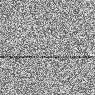

In [0]:
array_to_img(X[1])

In [0]:
img = create_ring()

In [0]:
def cnn(opt=False, drop=False):
  if not opt:
    opt = Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
    
  model = Sequential()
  model.add(Conv2D(6, kernel_size=(3, 3), activation='relu', data_format='channels_last', input_shape=(95, 95, 1,)))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', data_format='channels_last'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Conv2D(12, kernel_size=(3, 3), activation='relu', data_format='channels_last'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Flatten())
  
  model.add(Dense(1024, activation='relu', kernel_initializer='glorot_uniform'))
  if drop:
    model.add(Dropout(0.4))
    
  model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))
  model.compile(loss='binary_crossentropy', 
                optimizer=opt,
                metrics=['accuracy'])
  
  return model

# train with circles and rings w/out camouflage

In [0]:
imgs, labels = create_db()
imgs = np.array(imgs)/255
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [0]:
model = cnn(drop=True)

model.summary()

h = model.fit(np.array(X_train), np.array(y_train), epochs=10, validation_data=(np.array(X_valid), np.array(y_valid)))

W0901 16:38:26.373595 140062005540736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0901 16:38:26.377863 140062005540736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0901 16:38:26.380654 140062005540736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0901 16:38:26.418297 140062005540736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0901 16:38:26.495181 140062005540736 deprecation_wrapp

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 93, 93, 6)         60        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 8)         440       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 12)        876       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 12)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1200)             

In [0]:
test_loss, test_acc = model.evaluate(np.array(X_test), np.array(y_test))

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

100/100 [==============================] - 0s 361us/step
Test loss: 0.22851068496704102
Test accuracy: 0.87


## test on camouflaged

In [0]:
cam, corr = create_db(camouflage=True)
cam = np.array(cam)/255

In [0]:
preds = model.predict(np.array(cam))

In [0]:
c = 0
for y, p in zip(corr, preds):
  pr = 0
  if p > 0.5:
    pr = 1
  if pr == y:
    c += 1
print(c/len(corr))

0.501


## train on camouflaged on top of model

In [0]:
cam_tr, lab_tr = create_db(camouflage=True)
cam_tr = np.array(cam_tr)/255
X_train, X_valid, y_train, y_valid = train_test_split(cam_tr, lab_tr, test_size=0.1, random_state=42)

In [0]:
model.fit(np.array(X_train), np.array(y_train), epochs=3, validation_data=(np.array(X_valid), np.array(y_valid)))

Train on 900 samples, validate on 100 samples
Epoch 1/3
900/900 [==============================] - 0s 472us/step - loss: 0.8291 - acc: 0.5711 - val_loss: 0.6692 - val_acc: 0.5700
Epoch 2/3
900/900 [==============================] - 0s 446us/step - loss: 0.6309 - acc: 0.6633 - val_loss: 0.5990 - val_acc: 0.7900
Epoch 3/3
900/900 [==============================] - 0s 425us/step - loss: 0.5550 - acc: 0.7856 - val_loss: 0.4917 - val_acc: 0.8300


In [0]:
model.fit(np.array(X_train), np.array(y_train), epochs=2, validation_data=(np.array(X_valid), np.array(y_valid)))

Train on 900 samples, validate on 100 samples
Epoch 1/2
900/900 [==============================] - 0s 441us/step - loss: 0.4720 - acc: 0.8178 - val_loss: 0.4061 - val_acc: 0.9100
Epoch 2/2
900/900 [==============================] - 0s 441us/step - loss: 0.4025 - acc: 0.8511 - val_loss: 0.3558 - val_acc: 0.9000


## now test again

In [0]:
preds = model.predict(np.array(cam))

In [0]:
c = 0
for y, p in zip(corr, preds):
  pr = 0
  if p > 0.5:
    pr = 1
  if pr == y:
    c += 1
print(c/len(corr))

0.857


ALSO wanna test for the clean images as well, to see if anything changed

In [0]:
test_loss, test_acc = model.evaluate(np.array(X_test), np.array(y_test))

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

100/100 [==============================] - 0s 258us/step
Test loss: 0.7629923705756664
Test accuracy: 0.8


## test on camouflaged horizontal and vertical

In [0]:
hoz_cam, hoz_lab = create_db_hoz_vec(camouflage=True)
hoz_cam = np.array(hoz_cam)/255

In [0]:
hoz_preds = model.predict(np.array(hoz_cam))

In [0]:
c = 0
for hp, l in zip(hoz_preds, hoz_lab):
  hr = 0
  if hp > 0.5:
    hr = 1
  if hr == l:
    c += 1
print(c/len(hoz_lab))

0.323


## Slightly train and test again

in order to simulate "learning" that would naturally occur in the bees, train the model with a small batch of 100 camouflaged horizontal and vertical patterns

In [0]:
tr_hz, tr_lb = create_db_hoz_vec(num=100, camouflage=True)
tr_hz = np.array(tr_hz)/255

In [0]:
model.fit(np.array(tr_hz), np.array(tr_lb), epochs=3)

Epoch 1/3
100/100 [==============================] - 0s 515us/step - loss: 1.1057 - acc: 0.2500
Epoch 2/3
100/100 [==============================] - 0s 537us/step - loss: 0.9196 - acc: 0.2700
Epoch 3/3
100/100 [==============================] - 0s 539us/step - loss: 0.7860 - acc: 0.3400


In [0]:
model.fit(np.array(tr_hz), np.array(tr_lb), epochs=2)

Epoch 1/2
100/100 [==============================] - 0s 599us/step - loss: 0.6977 - acc: 0.4700
Epoch 2/2
100/100 [==============================] - 0s 536us/step - loss: 0.6584 - acc: 0.6400


In [0]:
hoz_preds = model.predict(np.array(hoz_cam))

In [0]:
c = 0
for hp, l in zip(hoz_preds, hoz_lab):
  hr = 0
  if hp > 0.5:
    hr = 1
  if hr == l:
    c += 1
print(c/len(hoz_lab))

0.575


# train with camouflage for reference

In [0]:
imgs, labels = create_db(camouflage=True)
imgs = np.array(imgs)/255
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [0]:
model = cnn(drop=True)

model.summary()

h = model.fit(np.array(X_train), np.array(y_train), epochs=10, validation_data=(np.array(X_valid), np.array(y_valid)))

W0831 12:49:56.602632 140517717784448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0831 12:49:56.605166 140517717784448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0831 12:49:56.611889 140517717784448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0831 12:49:56.644824 140517717784448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0831 12:49:56.703186 140517717784448 deprecation_wrapp

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 93, 93, 6)         60        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 8)         440       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 12)        876       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 12)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1200)             

In [0]:
h2 = model.fit(np.array(X_train), np.array(y_train), epochs=20, validation_data=(np.array(X_valid), np.array(y_valid)))

Train on 810 samples, validate on 90 samples
Epoch 1/20
810/810 [==============================] - 0s 420us/step - loss: 0.5891 - acc: 0.7099 - val_loss: 0.6957 - val_acc: 0.4556
Epoch 2/20
810/810 [==============================] - 0s 398us/step - loss: 0.5690 - acc: 0.7123 - val_loss: 0.6736 - val_acc: 0.5667
Epoch 3/20
810/810 [==============================] - 0s 375us/step - loss: 0.5337 - acc: 0.7753 - val_loss: 0.6941 - val_acc: 0.6222
Epoch 4/20
810/810 [==============================] - 0s 372us/step - loss: 0.5256 - acc: 0.7519 - val_loss: 0.6549 - val_acc: 0.5556
Epoch 5/20
810/810 [==============================] - 0s 373us/step - loss: 0.4779 - acc: 0.7963 - val_loss: 0.6429 - val_acc: 0.6333
Epoch 6/20
810/810 [==============================] - 0s 364us/step - loss: 0.4527 - acc: 0.8296 - val_loss: 0.6292 - val_acc: 0.5889
Epoch 7/20
810/810 [==============================] - 0s 374us/step - loss: 0.4171 - acc: 0.8642 - val_loss: 0.6042 - val_acc: 0.6333
Epoch 8/20
810/81

In [0]:
h3 = model.fit(np.array(X_train), np.array(y_train), epochs=10, validation_data=(np.array(X_valid), np.array(y_valid)))

Train on 810 samples, validate on 90 samples
Epoch 1/10
810/810 [==============================] - 0s 426us/step - loss: 0.1304 - acc: 0.9617 - val_loss: 0.2697 - val_acc: 0.9000
Epoch 2/10
810/810 [==============================] - 0s 388us/step - loss: 0.1021 - acc: 0.9802 - val_loss: 0.2655 - val_acc: 0.9111
Epoch 3/10
810/810 [==============================] - 0s 389us/step - loss: 0.1158 - acc: 0.9728 - val_loss: 0.2876 - val_acc: 0.9000
Epoch 4/10
810/810 [==============================] - 0s 396us/step - loss: 0.0862 - acc: 0.9914 - val_loss: 0.3148 - val_acc: 0.8444
Epoch 5/10
810/810 [==============================] - 0s 373us/step - loss: 0.0796 - acc: 0.9852 - val_loss: 0.2920 - val_acc: 0.8778
Epoch 6/10
810/810 [==============================] - 0s 373us/step - loss: 0.0761 - acc: 0.9901 - val_loss: 0.2680 - val_acc: 0.9111
Epoch 7/10
810/810 [==============================] - 0s 369us/step - loss: 0.0817 - acc: 0.9741 - val_loss: 0.2459 - val_acc: 0.8889
Epoch 8/10
810/81

In [0]:
test_loss, test_acc = model.evaluate(np.array(X_test), np.array(y_test))

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

100/100 [==============================] - 0s 298us/step
Test loss: 0.502575997710228
Test accuracy: 0.8
